<a href="https://colab.research.google.com/github/nitesr/tryml/blob/main/sam_mask_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-c5prkqvf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-c5prkqvf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=0956962afdfcefa41d517d479bb888931bc217872357d472a661fdfabd8fba48
  Stored in directory: /tmp/pip-ephem-wheel-cache-064ex_ak/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
mkdir: cannot create directory ‘images’: File exists
--2024-03-14 00:44:22--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolvi

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [12]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_masked_image(img, masks, scores):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        show_mask(mask, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        # plt.axis('off')
        plt.show()

def show_generated_masks(masks, ax):
   if len(masks) == 0:
       return
   sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
   ax.set_autoscale_on(False)
   for mask in sorted_masks:
       m = mask['segmentation']
       img = np.ones((m.shape[0], m.shape[1], 3))
       color_mask = np.random.random((1, 3)).tolist()[0]
       for i in range(3):
           img[:,:,i] = color_mask[i]
       np.dstack((img, m*0.35))
       ax.imshow(np.dstack((img, m*0.35)))

       bbox = mask['bbox']
       rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2,
                         edgecolor='r', facecolor="none")
       ax.add_patch(rect)

In [4]:
import sys
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sys.path.append("..")


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.eval()
sam.to(device=device)

predictor = SamPredictor(sam)
sam_mask_generator = SamAutomaticMaskGenerator(sam)

77 0.9748508605090055


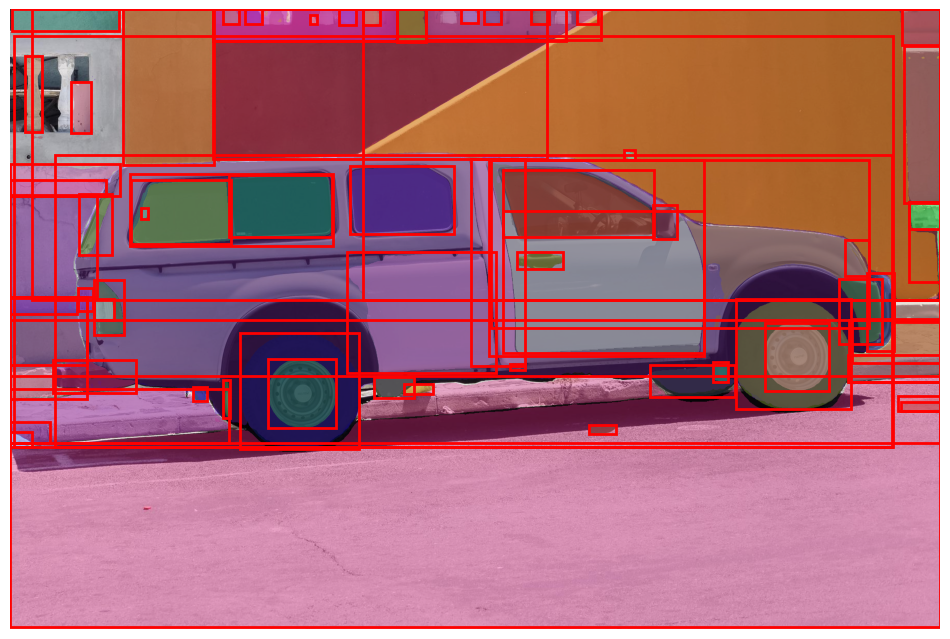

In [13]:
import os

image_path = './images/truck.jpg'
image_name = image_path.split(os.path.sep)[-1]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = sam_mask_generator.generate(image)
avg_score = np.mean(np.array([ mask['stability_score'] for mask in masks ]))
print(len(masks), avg_score)

plt.figure(figsize=(12, 9))
plt.imshow(image)
show_generated_masks(masks, plt.gca())
plt.axis('off')
plt.savefig(os.path.join('./outputs', image_name), bbox_inches='tight')

del masks
del image

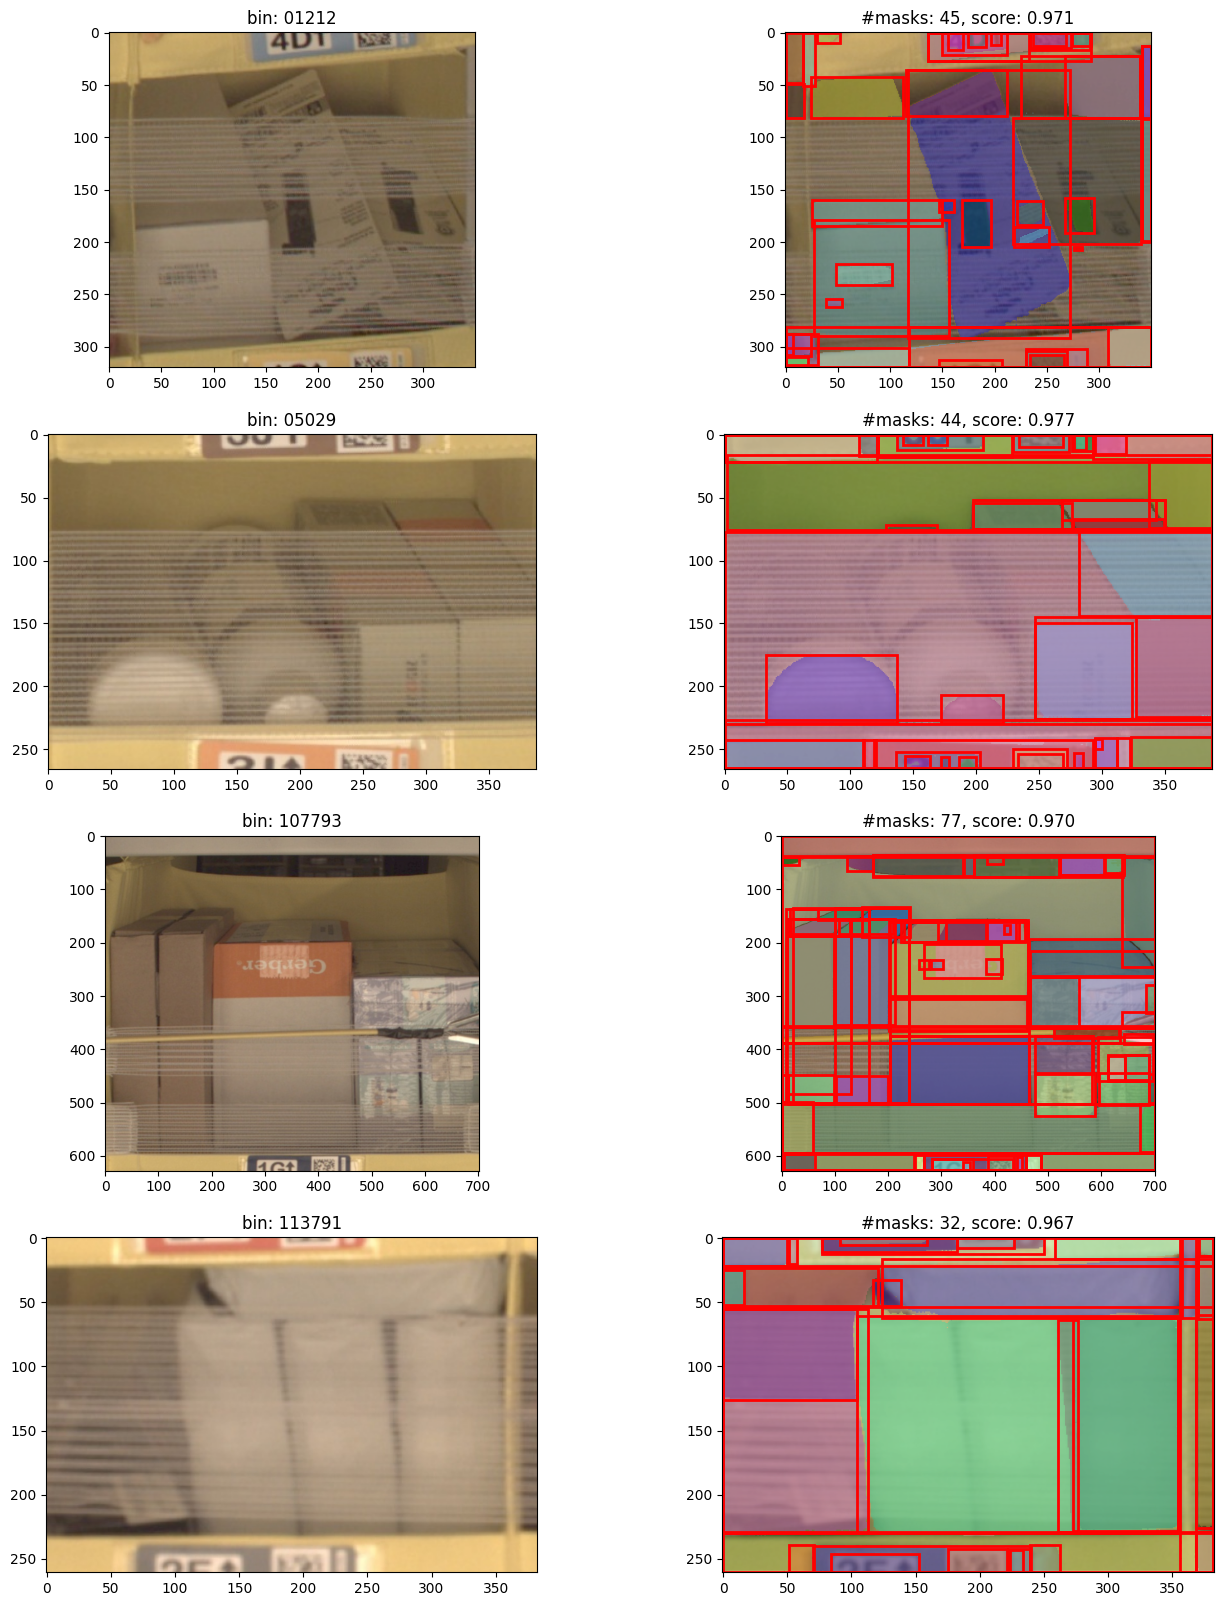

In [14]:
import numpy as np

img_ids = ['01212', '05029', '107793', '113791']

rows = len(img_ids)
fig, axs = plt.subplots(rows, 2, figsize=(16, 5*rows))
for r in range(0, rows):
    image_path = os.path.join("images", f"{img_ids[r]}.jpg")
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    masks = sam_mask_generator.generate(img)
    axs[r][0].imshow(img)
    axs[r][0].set_title(f"bin: {img_ids[r]}")

    axs[r][1].imshow(img)
    avg_score = np.mean(np.array([ mask['stability_score'] for mask in masks ]))

    show_generated_masks(masks, axs[r][1])
    axs[r][1].set_title(f"#masks: {len(masks)}, score: {avg_score:.3f}")

    del masks
    del img

plt.savefig(os.path.join('./outputs', "collection.jpg"), bbox_inches='tight')
plt.show()